In [5]:
import yfinance as yf
import pandas as pd 

from scipy import stats
import pylab
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

###### The aim is to test whether this effect can still be seen in the returns of the Italian index in 2022.

###### THypothesis H0(null) : The average of Monday's returns will be statistically equal to the average of the previous Friday.

###### THypothesis H1(alternative): The averages of the returns will be different statistically 

In [8]:
milan_data = yf.download("FTSEMIB.MI",start="2022-01-01",end="2023-01-01")
milan_data["returns"] = milan_data.Close.pct_change()*100

[*********************100%%**********************]  1 of 1 completed


In [9]:
milan_data

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2022-01-03,27409.0,27779.0,27409.0,27730.0,27730.0,403410700,NaN
2022-01-04,27897.0,28084.0,27753.0,27955.0,27955.0,427310400,0.811396
2022-01-05,28002.0,28213.0,27951.0,28163.0,28163.0,459306200,0.744053
2022-01-06,27738.0,27942.0,27601.0,27656.0,27656.0,413528200,-1.800234
2022-01-07,27776.0,27853.0,27449.0,27618.0,27618.0,389938700,-0.137402
...,...,...,...,...,...,...,...
2022-12-23,23830.0,23938.0,23773.0,23878.0,23878.0,253043700,0.272960
2022-12-27,24033.0,24081.0,23808.0,23856.0,23856.0,216142900,-0.092135
2022-12-28,23850.0,23913.0,23721.0,23770.0,23770.0,283942900,-0.360496


In [11]:
milan_data["day_week_name"] = milan_data.index.day_name()
milan_data["day_week_num"] = milan_data.index.day_of_week
milan_data["week_year"] = milan_data.index.isocalendar().week
milan_data["year"] = milan_data.index.year
milan_data["year_week"] = milan_data["year"].astype(str) + "_" + milan_data["week_year"].astype(str)
milan_data


,Open,High,Low,Close,Adj Close,Volume,returns,day_week_name,day_week_num,week_year,year,year_week
Date,,,,,,,,,,,,
2022-01-03,27409.0,27779.0,27409.0,27730.0,27730.0,403410700,NaN,Monday,0,1,2022,2022_1
2022-01-04,27897.0,28084.0,27753.0,27955.0,27955.0,427310400,0.811396,Tuesday,1,1,2022,2022_1
2022-01-05,28002.0,28213.0,27951.0,28163.0,28163.0,459306200,0.744053,Wednesday,2,1,2022,2022_1
2022-01-06,27738.0,27942.0,27601.0,27656.0,27656.0,413528200,-1.800234,Thursday,3,1,2022,2022_1
2022-01-07,27776.0,27853.0,27449.0,27618.0,27618.0,389938700,-0.137402,Friday,4,1,2022,2022_1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,23830.0,23938.0,23773.0,23878.0,23878.0,253043700,0.272960,Friday,4,51,2022,2022_51
2022-12-27,24033.0,24081.0,23808.0,23856.0,23856.0,216142900,-0.092135,Tuesday,1,52,2022,2022_52
2022-12-28,23850.0,23913.0,23721.0,23770.0,23770.0,283942900,-0.360496,Wednesday,2,52,2022,2022_52


In [14]:
datas_mon_fri = milan_data[(milan_data["day_week_name"] == "Monday")|(milan_data["day_week_name"] == "Friday")]

In [20]:
datas_mon_fri

,Open,High,Low,Close,Adj Close,Volume,returns,day_week_name,day_week_num,week_year,year,year_week
Date,,,,,,,,,,,,
2022-01-03,27409.0,27779.0,27409.0,27730.0,27730.0,403410700,NaN,Monday,0,1,2022,2022_1
2022-01-07,27776.0,27853.0,27449.0,27618.0,27618.0,389938700,-0.137402,Friday,4,1,2022,2022_1
2022-01-10,27779.0,27803.0,27273.0,27354.0,27354.0,352259500,-0.955898,Monday,0,2,2022,2022_2
2022-01-14,27598.0,27737.0,27422.0,27544.0,27544.0,406157900,-1.077431,Friday,4,2,2022,2022_2
2022-01-17,27678.0,27705.0,27574.0,27689.0,27689.0,356541300,0.526430,Monday,0,3,2022,2022_3
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,24173.0,24353.0,24133.0,24304.0,24304.0,345228100,0.111216,Monday,0,50,2022,2022_50
2022-12-16,23739.0,23815.0,23505.0,23688.0,23688.0,668735500,-0.160162,Friday,4,50,2022,2022_50
2022-12-19,23765.0,23912.0,23661.0,23684.0,23684.0,335971100,-0.016886,Monday,0,51,2022,2022_51


In [33]:
datas_mean = datas_mon_fri[["day_week_num","day_week_name","returns"]].groupby(["day_week_num","day_week_name"]).mean()
datas_mean = datas_mean.droplevel(0,axis=0)
datas_sem = datas_mon_fri[["day_week_num","day_week_name","returns"]].groupby(["day_week_num","day_week_name"]).sem()
datas_sem = datas_sem.droplevel(0,axis=0)
union_ = pd.concat([datas_mean,datas_sem],axis=1)
union_.columns = ["Mean_return","SEM_return"]
union_




,Mean_return,SEM_return
day_week_name,,
Monday,-0.188733,0.196517
Friday,-0.095248,0.259043


In [45]:
fig = go.Figure()
fig.add_trace(go.Bar(name='Returns',x=union_.index, y=union_.Mean_return,
                    error_y=dict(type='data',array=union_.SEM_return),
                    marker_color="orange",orientation='v'))

fig.update_layout(title_text="<b>Returns FTSEMIB.MI<b>",
                 xaxis_title ="Day of the week",
                 yaxis_title = "Average daily return",
                 template="none",margin=dict(l=75,r=20,t=75,b=75),
                 paper_bgcolor="#f7f8fa")

In [51]:
datas = {"Date":[], "Monday":[], "Friday":[], "Week_monday":[], "week_friday":[]}

for i in range(1,len(datas_mon_fri)):
    if (datas_mon_fri.iloc[i-1]["day_week_name"]=="Friday") and (datas_mon_fri.iloc[i]["day_week_name"]=="Monday"):
        if (datas_mon_fri.iloc[i-1]["week_year"]==datas_mon_fri.iloc[i]["week_year"]-1):
            datas["Date"].append(datas_mon_fri.index[i])
            datas["Monday"].append(datas_mon_fri.iloc[i]["returns"])
            datas["Week_monday"].append(datas_mon_fri.iloc[i]["year_week"])
            datas["Friday"].append(datas_mon_fri.iloc[i-1]["returns"])
            datas["week_friday"].append(datas_mon_fri.iloc[i-1]["year_week"])
            


df_analysi = pd.DataFrame(datas)
df_analysi.head(10)


,Date,Monday,Friday,Week_monday,week_friday
0,2022-01-10,-0.955898,-0.137402,2022_2,2022_1
1,2022-01-17,0.526430,-1.077431,2022_3,2022_2
2,2022-01-24,-4.020546,-1.846210,2022_4,2022_3
3,2022-01-31,0.937324,-1.179228,2022_5,2022_4
4,2022-02-07,-1.033679,-1.790395,2022_6,2022_5
5,2022-02-14,-2.043314,-0.823832,2022_7,2022_6
6,2022-02-21,-1.724073,-0.607447,2022_8,2022_7
7,2022-02-28,-1.385171,3.597556,2022_9,2022_8
8,2022-03-07,-1.357667,-6.235653,2022_10,2022_9
9,2022-03-14,1.675275,0.672871,2022_11,2022_10


In [52]:
 df_analysi["diff_fri_mond"] = df_analysi.Friday - df_analysi.Monday

In [58]:
test_norma = stats.normaltest( df_analysi["diff_fri_mond"])
test_norma
#we must check if we have a normal distribuition
#pvalue greater then 0.05 we consider hypothesis H0 to be true 
#we have a normal distribuition 

NormaltestResult(statistic=1.3485076229356623, pvalue=0.5095364890734168)

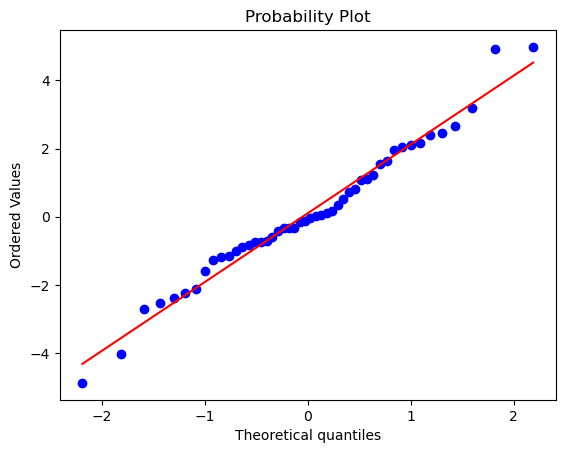

In [57]:
stats.probplot(df_analysi["diff_fri_mond"],dist="norm",plot=pylab)
pylab.show()

In [60]:
stats.ttest_rel(df_analysi.Monday,df_analysi.Friday )

TtestResult(statistic=-0.3545569027061098, pvalue=0.7245075226549822, df=47)

# now we can conclude that Monday and Friday returns have no 
# statistically significant difference between them 